# Introduction to Spatial Clustering

-----

In this notebook, we introduce [cluster finding][wcl], a machine learning task where one tries to identify groups or clusters of data. Clustering is generally an unsupervised learning technique, since we are simply using the data features to determine some concept of _closeness_. One common technique used to quantify clustering is to identify clusters by using a metric, or distance measure. For example, we can use the [_Euclidean metric_][edm] when all the data have the same units (such as distance) and dimensions. Other distance measures can be used when appropriate for the given data to determine closeness or similarity.

Specifically, this notebook focuses on [k-means clustering][wkm], where we seek to divide $N$ data points into $k$ clusters. First, the k-means algorithm will be introduced and demonstrated on the Iris data. Next, the _elbow method_ is introduced as a technique for determining the best value for $k$. Finally, this cluster finding technique will be demonstrated on the larger, handwritten digit data, which will also include a discussion on the algorithm's performance, as well as the use of PCA, and manifold earning with cluster finding.

-----
[wcl]: https://en.wikipedia.org/wiki/Cluster_analysis
[edm]: https://en.wikipedia.org/wiki/Euclidean_distance
[wkm]: https://en.wikipedia.org/wiki/K-means_clustering

## Table of Contents

[Formalism](#Formalism)

[k-Means: Iris Data](#k-Means:-Iris-Data)
- [k-Means:Elbow Method](#k-Means:Elbow-Method)

[k-Means: Digit Data](#k-Means:-Digit-Data)
- [k-Means: Performance](#k-Means:-Performance)
- [k-Means: Dimensional Reduction](#k-Means:-Dimensional-Reduction)
- [k-Means: Manifold Learning](#k-Means:-Manifold-Learning)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

Data often have naturally occurring groups or clusters; we have used this fact to perform classification. In some cases, however, we wish to understand the groups, or clusters themselves. Thus, we also need to find the clusters in order to quantify their properties (such as size or density) as well as to identify their members. Formally, cluster finding seeks to first find $k$ clusters from a set of $N$ data points, and to subsequently identify which data points belong to each cluster. 

While there are a number of different approaches to clustering, one of the easiest to understand is the k-means algorithm. In this algorithm we start with a guess for $k$, the number of clusters (this can be based on prior information or iteratively quantified). We randomly place cluster centers in the data and determine how well the data _cluster_ to these cluster centers. This information is used to pick new cluster centers, via a weighting process (for the k-means algorithm we take the mean of the points assigned to each cluster), and the process continues until a solution converges (or we reach a predefined number of iterations). 

In general, the k-means algorithm can be quite fast. However, as $N$ becomes larger, this task can become computationally difficult since the distances between each cluster center and each data point must be repeatedly calculated. In addition, the k-means algorithm is iterative where the cluster centers are repeatedly updated, and new distances calculated. Finally, the k-means algorithm can become trapped in a local minima. To avoid this, the k-means algorithm is typically run multiple times, each with a different set of random cluster locations, and the best result is selected in the end.

Given a set of random, initial cluster locations, the k-means algorithm has two steps, over which the algorithm iterates until the process is completed:

- **Assignment Step**: each data point is assigned to the closest cluster (typically computed by using the Euclidean distance).
- **Update Step**: the new cluster centers are computed by taking the mean of all data points that have been assigned to each cluster.

This iteration completes either when there is no change to the data during the assignment step or when the pre-defined number of iterations has completed.



-----

[[Back to TOC]](#Table-of-Contents)


## k-Means: Iris Data

To introduce the k-means cluster algorithm, we will start by using the standard Iris data set. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width. The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris Setosa, Iris Versicolor, and Iris Virginica. 

Before proceeding with the k-means algorithm, we first need to load and pre-process these data. The following Code cell loads the Iris data into the notebook and extracts the features and labels. Next, the features are scaled to all have zero mean and unit standard deviation. This ensures each feature is treated uniformly during the cluster finding process. Next, we also create a two-dimensional representation of the Iris data by using principal component analysis. This reduced set of features (and labels) will be used to visualize the results of the k-means algorithm.

-----

In [2]:
import sklearn.datasets as ds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the digits data
iris = ds.load_iris()
    
# Extract the data and labels
x = StandardScaler().fit_transform(iris.data)
y = iris.target.reshape(x.shape[0], 1)

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
xx = pca.fit_transform(x)

# Create reduced data set
data = np.concatenate((xx, y), axis=1)

-----

### k-Means: Clustering

We perform k-means clustering by using the [`KMeans`][skkm] estimator within the `cluster` module of the scikit learn library. This algorithm accepts a number of hyperparameters that control its performance, some of the most commonly changed include:
- `n_clusters`: the number of clusters, $k$, the algorithm will find, the default value is eight.
- `n_init`: the number of times the algorithm is run with different initial cluster centers, the default is ten.
- `max_iter`: maximum number of iterations for the algorithm in any given run, the default is 300.
- `random_state`: random seed used by the random number generator, enables reproducibility.

In the following Code cell, we perform k-means cluster finding on the Iris data. We create the estimator by specifying three clusters (one for each species), by indicating that twenty-five different runs should be performed, and by specifying a random state. After the estimator is created, we `fit` the model to the data which identifies the cluster centers. Note, this process is unsupervised in that we do not use the label array in this process. In addition, for now we perform the cluster finding by using all features (which in this case is four). After we find our cluster centers, we `predict` to which cluster each data point belongs. To use these results, we must reshape the array to be a two-dimensional matrix.

-----
[skkm]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [3]:
# We will use kmeans form scikit-learn
from sklearn.cluster import KMeans

# We build our model assuming three clusters
k_means = KMeans(n_clusters=3, n_init=25, random_state=23)

# We fit our data to assign classes
k_means.fit(x)

# Obtain the predictions
y_pred = k_means.predict(x).reshape(y.shape[0], 1)

-----

We can extract the cluster centers (sometimes called the _centroids_) by using the `cluster_centers_` attribute on the estimator. Since we found the clusters in a four-dimensional space, to visualize the cluster centers we must transform the computed centers to the reduced principal components, which we can do by using our pre-defined PCA transformer. The following Code cell performs this operation, and displays the individual cluster centers in principal components space.


-----

In [4]:
# Compute cluster centers, and transform 
# to principal component space
cc = k_means.cluster_centers_
cc_pca = pca.transform(cc)

# Display cluster centers
for idx, xy_c in enumerate(cc_pca):
    print(f'Cluster {idx} center located at ({xy_c[0]:4.2f}, {xy_c[1]:4.2f})')

Cluster 0 center located at (-2.22, 0.29)
Cluster 1 center located at (1.72, 0.60)
Cluster 2 center located at (0.57, -0.81)


-----

We now visualize the original data, the assigned cluster, and the cluster centers in our two-dimensional principal component space. The following Code cell creates this visualization. First, the colors and labels used for the original data and the assigned cluster are defined. Next, DataFrames are created for the original data and the data with cluster labels. Finally, the visualization is created by plotting the cluster centers as large, black Xs, plotting the original data as semi-transparent, large circles, and plotting the cluster labels as solid, small circles.

The resulting figure indicates that the _Setosa_ data are easily distinguished by a separate cluster. On the other hand, the _Versicolor_ and _Virginica_ data are intermixed. However, recall that this cluster finding technique is unsupervised, the original labels were only applied after the clusters were identified. Given the natural blending of these two species, the algorithm still does remarkably well.

-----

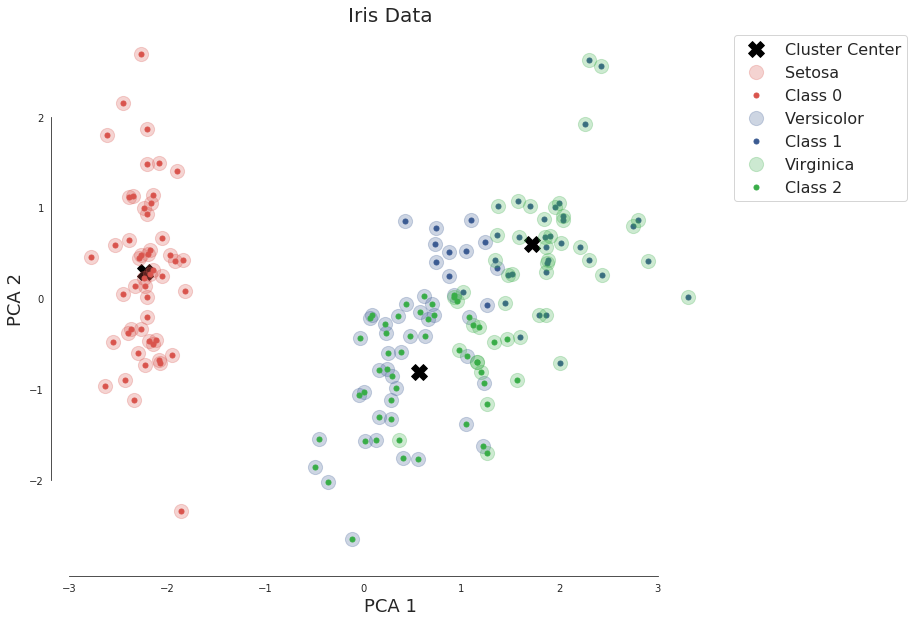

In [5]:
# Now we compare the cluster assignments to the real classes.

# Two sets of colors, can modify these to ensure colors match 
# between known and predicted clusters.
clr = [sns.xkcd_rgb['pale red'], 
       sns.xkcd_rgb['denim blue'], 
       sns.xkcd_rgb['medium green']]

pclr = [sns.xkcd_rgb['pale red'], 
        sns.xkcd_rgb['denim blue'],
        sns.xkcd_rgb['medium green']]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
plbls = ['Class 0', 'Class 1', 'Class 2']

# Data
cols = ['PCA1', 'PCA2', 'Species']
dt = pd.DataFrame(data, columns = cols)

# Predicted Clusters
pc = pd.DataFrame(np.concatenate((xx, y_pred), axis=1), 
                  columns = cols)

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot cluster centers
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', 
           label='Cluster Center')

# Plot each species separately
for idx in range(3):
    
    # Plot species as large points
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], 
               color=clr[idx], label=lbls[idx], alpha=0.25, s=200)

    # Plot assignd cluster as small point
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=pclr[idx], label=plbls[idx], alpha=1, s=25)

# Decorate Plot
ax.set(title='Iris Data', xlabel='PCA 1', ylabel='PCA 2')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2)
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)


### k-Means: Elbow Method

Clearly, one of the biggest challenges in using the k-means algorithm to find clusters is in selecting the value of $k$. In some cases, there might be a strong a priori reason to choose a specific value for $k$, such as with the Iris data and $k=3$. For a general data set, on the other hand, we need a method to identify the _best_ value for $k$. In these cases, the _elbow method_ provides a heuristic estimate that can provide a reasonable value.

The elbow method has several forms, all of which rely on some measure of the quality with which a given number of clusters best fits the data. In this notebook, we will use the cluster inertia, which is the sum total distance of every point to its cluster center. When the inertia is plotted against the number of clusters, the value starts high for small numbers of clusters, and as the number of clusters increases, this value will quickly decrease. This decrease arises since more clusters will, on average, reduce the distance between any given point and its cluster center. Eventually, however, the inertia levels off as existing clusters are broken into sub-groups. The **best** value for $k$ is selected as the _elbow_ point within this plot.

The following two Code cells demonstrate the _elbow method_. The first Code cell performs k-means clustering for different numbers of clusters. The other parameters are fixed, including the number of runs used to find the best cluster centers at ten, and the random state. For each set of computed cluster centers, the inertia is assigned to the `distances` array. The second Code cell plots the number of clusters versus the corresponding _inertia_. Notice how the _elbow_ is clearly seen at three clusters, where the steep drop changes to a much shallower slope.

-----

In [6]:
# Search for best number of clusters, from one to ten
n_clusters = np.arange(1, 11)
distances = np.zeros(n_clusters.shape[0])

# Perform k-means clustering for different numbers of clusters
# Use the inertia (or sum of total distances between points
# and cluster centers) as the performance metric.
for idx, nc in enumerate(n_clusters):
    # We build our model for nc clusters
    model = KMeans(n_clusters=nc, n_init=10, random_state=23)
    model.fit(x)
    distances[idx] = model.inertia_

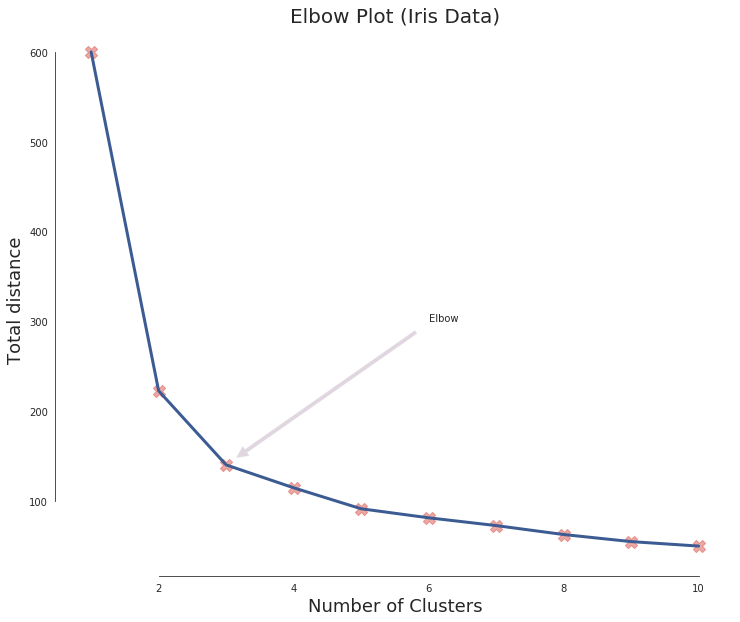

In [7]:
# Plot elbow method
fig, ax = plt.subplots(figsize=(12, 10))

# Draw points and connect them
ax.scatter(n_clusters, distances, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_clusters, distances, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'])

# Define elbow at three clusters
elb = (n_clusters[2], distances[2])

# Draw an arrow showing the elbow
ax.annotate('Elbow', xytext=[6, 300], xy=elb,
                arrowprops=dict(facecolor=sns.xkcd_rgb['dusty purple'], 
                                alpha=0.25, shrink=0.05))

# Decorate Plot
ax.set(title='Elbow Plot (Iris Data)', 
       xlabel='Number of Clusters', 
       ylabel='Total distance')
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)


## k-Means: Digit Data

While the Iris data enabled a simple introduction to the k-means algorithm and cluster finding in general, most data sets will contain more features. As a result, we now switch to a second type of data with more features. Specifically, in the rest of this notebook we will apply the k-means algorithm to the handwritten digit data set, which contains sixty-four features (each feature is a different pixel in the eight by eight pixel images). 

The first Code cell below loads the digit data into the notebook. The second Code cell plots the first ten images, which are each different numbers, to provide a quick visual foundation for how the images (and their pixels) are similar and different. The plotting code used in the second Code cell is contained in a separate file in the same directory as this notebook to minimize distractions.


-----

In [8]:
import sklearn.datasets as ds

# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target
images = digits.images

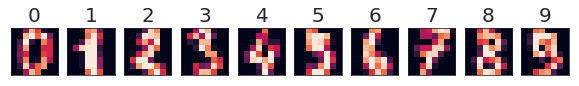

In [9]:
# Plot images using helper code
from helper_code import mlplots as mp
mp.plot_images(images[:10], y[:10])

-----

### Clustering Image Data

Now that these data are loaded, we can apply the k-means algorithm to determine how these data cluster. To do this, we create in the first Code cell a `KMeans` estimator, and specify ten clusters, twenty-five runs of the algorithm with different initial, random cluster locations, and a random state. Once this estimator is created, we use the `fit` method to determine the actual cluster centers. The second Code cell displays a confusion matrix to provide insight into how well the discovered clusters represent the natural image labels. 

One challenge with this visualization is that there is not a direct mapping between the actual image label and the assigned cluster label (since the k-means algorithm was unsupervised and unaware of the true labels). Looking at the matrix, it appears that every image but the number six has a dominant cluster. The number six appears to be split fairly evenly across the clusters one and eight.

To aid in the interpretation of the confusion matrix (and to aid in our understanding of how the k-means algorithm performed with the digit data, in the third Code cell below, we generate and display images for each of the ten clusters identified by the k-means algorithm. This is accomplished by taking the cluster centers in the sixty-four dimensional feature space and reshaping this into an eight x eight image. These images are plotted, and confirm what was shown in the confusion matrix, namely all clusters are mapped fairly clearly to an existing number, except for cluster six, which looks ambiguous.

-----

In [10]:
# We build our model assuming ten clusters
k_means = KMeans(n_clusters=10, n_init=25, random_state=23)

# We fit and transform our data to assign classes
model = k_means.fit(x)

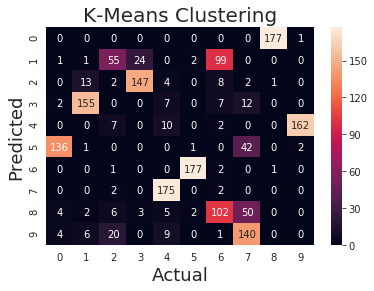

In [11]:
# Display known clusters versus k-means clusters
mp.confusion(y, model.predict(x), 
             np.arange(10), 10, 'K-Means Clustering')

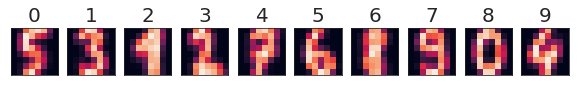

In [12]:
# Create images correspomnding to cluster center

# We need a 3D matrix, for each cluster, and each image is 8x8
cntrs = np.zeros((10, 8, 8))

# Iterate over the clusters.
for idx in range(10):   
    cntrs[idx] = model.cluster_centers_[idx, :].reshape(8, 8)

# Plot images
mp.plot_images(cntrs, np.arange(10))

-----

From the above confusion matrix and images, we see that cluster zero maps to the number five, cluster one maps to number three, all the way to cluster eight mapping to the number zero, and cluster nine mapping to the number four. The other interesting piece from these mappings is that when there is little confusion between a cluster and a number (e.g., clusters zero, five, eight, and nine) the image is clearly the correct number. On the other hand, when there is confusion, the image is less clear (e.g., cluster two). This mapping is clearly doing well, except for cluster six, which presents an ambiguous image, and has confusion between numbers one and eight.

We can also transform our original data into the cluster space and display the first image for each cluster in the transformed data set. This provides an additional check on the performance of the k-means algorithm on these data. The following Code cell first transforms the original digit data. Next, we find the first occurrence of each digit by using the NumPy `argmin` function. This provides the index into the transformed data for the first occurrence of each cluster (or the argument minimum). 

We use this index to select the appropriate image form the original image array. The selected images are displayed along with their cluster label. The images all match the results from the confusion matrix, and closely match the images generated from the cluster centers. The only exception is cluster six, which once again is ambiguous, although there are traces of the number eight.

----- 

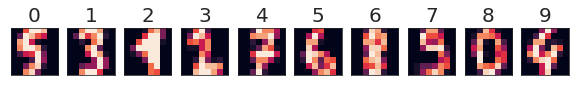

In [13]:
# Transform data into cluster space
ft_data = model.transform(x)

# Find image examples of each cluster and display
mp.plot_images(images[np.argmin(ft_data, axis=0)], np.arange(10))

-----
[[Back to TOC]](#Table-of-Contents)

### k-Means: Performance

The previous example demonstrated, visually, the performance of the k-means algorithm on the digit data. However, we often want a quantitative [measurement of performance][skpm]. Measuring the performance of a clustering algorithm is more challenging than scoring a classifier or regressor, especially since the process is unsupervised, and thus labels aren't always available. When labels are not available, we can, in some cases, compare the predicted labels from different clustering algorithms. When labels are available, we can compute similarity measures between the predicted and true labels.

The scikit learn library provides a number of different performance metrics for clustering, including the following:
- [Adjusted Rand Index][skari]: takes values in the range [-1, 1] and measures the similarity between predicted and true labels (or two different predicted sets of labels). This measure makes no assumptions made about the nature of the clusters (i.e., the shape of the clusters). Positive values indicate similar clustering, a score of one is perfect similarity, random labelling is close to zero, and independent labelling is less than zero.
- [Adjusted Mutual Info][skami]: takes values in the range [0, 1] and measures the agreement, normalizing against chance, between two sets of cluster labels (either predicted versus true, or two predicted sets of labels). This measure makes no assumption about the shape of the clusters. Random labelling has a score near zero, purely independent labels have a score of exactly zero, and equal clustering has a score of one.
- [Homogeneity][skh]: takes values in the range [0, 1] and measures the homogeneity of a cluster. This measure makes no assumption about the shape of the clusters. A value of one is a perfect score, the cluster contains only one type of data. As the cluster contains more types of data, the value decreases towards zero.
- [Completeness][skc]: takes values in the range [0, 1] and measures the completeness of how data are assigned to a cluster. This measure makes no assumption about the shape of the clusters. A value of one is a perfect score, all data of the same label are assigned to one cluster, as data are spread across more clusters, the value decreases towards zero.
- [V-measure][skv]: takes values in the range [0, 1] and is the harmonic mean of the homogeneity and completeness.
- [Fowlkes Mallows score][skfm]: takes values in the range [0, 1] and is the geometric mean of the precision and recall. Independent labels have values near zero, while labels that are in agreement have values close to one. This measure makes no assumption about the shape of the clusters. 
- [Silhouette][sks]: takes values in the range [-1, 1] and does not require ground truth labels. This score is based on the intra-cluster distance and the mean nearest-cluster distance (this is the distance to the closest cluster to which the data were not assigned). A value of one means highly dense clustering, and a value of minus one indicates incorrect clustering (since the data are often closer to a different cluster than the one to which they are assigned). A value of zero indicates overlapping clusters

The following Code cell computes these different performance metrics for the digit data. Since these scores are all positive and close to the maximum value of one, these metrics all indicate that our k-means clustering has identified reasonably good clusters. The only score that is lower is the silhouette score, which indicates that there is overlap between some of our clusters, which we saw in the confusion matrix, and the cluster images.

----
[skpm]: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
[skfm]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fowlkes_mallows_score.html
[skari]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
[skami]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html
[skh]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
[skc]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
[skv]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html
[sks]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [14]:
import sklearn.metrics as skm

# Cluster labels
lbls = model.labels_

# Compute performance metrics
ars = skm.adjusted_rand_score(y, lbls)
amis = skm.adjusted_mutual_info_score(y, lbls)

hs = skm.homogeneity_score(y, lbls)
cs = skm.completeness_score(y, lbls)
vms = skm.v_measure_score(y, lbls)

fms = skm.fowlkes_mallows_score(y, lbls)

ss = skm.silhouette_score(y.reshape(y.shape[0], 1), 
                          lbls.reshape(y.shape[0], 1), 
                          metric='euclidean')

# Display metrics, close to one is ideal
print(f'Adjusted rand score        = {ars:5.3f}')
print(f'Adjusted mutual info score = {amis:5.3f}')
print(f'Homogeneity score          = {hs:5.3f}')
print(f'Completeness score         = {cs:5.3f}')
print(f'V measure score            = {vms:5.3f}')
print(f'Fowlkes Mallows score      = {fms:5.3f}')
print(f'Silhouette (l2) score      = {ss:5.3f}')

Adjusted rand score        = 0.667
Adjusted mutual info score = 0.737
Homogeneity score          = 0.740
Completeness score         = 0.748
V measure score            = 0.744
Fowlkes Mallows score      = 0.701
Silhouette (l2) score      = 0.357


-----
[[Back to TOC]](#Table-of-Contents)


### k-Means: Dimensional Reduction

Finding clusters in high-dimensional data can be computationally intensive. For example, as the number of features increase, the distance calculation between each data point and each cluster center becomes more complex. Normally when faced with a data set that contains many features, we reduce the dimensionality of the task by performing dimension reduction. While we can also perform feature selection, information is lost that prevents an inverse transformation back to the original feature space, which means, for example, that we can't recover images in the original pixel space.

The following Code cells demonstrate how dimension reduction impacts cluster finding. First, we create a POCA transformation from the original sixty-four pixel feature space to a lower, twenty-dimensional space. This will explain approximately 90% of the variance in the original data. Next, we perform k-means clustering on this reduced data, with the same set of hyperparameters as before.

The next three Code cells provide insight into the performance of the k-means algorithm on this transformed data. First, we generate a confusion matrix for these data. The confusion matrix looks similar to the first, of course the cluster labels are different than before since the data have changed. Second, we generate images for the new cluster centers. This process is complicated since we must inverse transform the cluster centers back into the original sixty-four dimensional pixel space. 

Again, the cluster center images seem similar to the original set of cluster center images, although there might be a slight decrease in the quality of a few of the clusters (e.g., clusters one and nine are somewhat ambiguous). Finally, we compute the V-measure to demonstrate the quality of the clustering on these reduced dimensional data. This score is close to the previous value, indicating the reduction in dimensions did not significantly affect the cluster finding process.

----

In [15]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Number of components to retain, default to 20, 
# which is roughly 90% explained variance
num_cmpts = 20

# Compute PCA for digit data and transform
pca = PCA(n_components=num_cmpts, copy=True, random_state=23)
data = pca.fit_transform(x)

# We build our model assuming ten clusters
mdl = KMeans(n_clusters=10, n_init=25, random_state=23)

# We fit and transform our data to assign classes
mdl = mdl.fit(data)

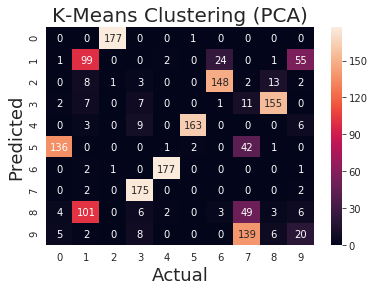

In [16]:
from helper_code import mlplots as mlp

# Display confusion matrix
mlp.confusion(y, mdl.predict(data), 
              np.arange(10), 10, 'K-Means Clustering (PCA)')

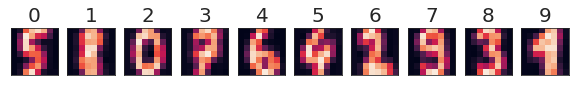

In [17]:
# Generate and display cluster center images
cntrs = np.zeros((10, 8, 8))

for idx in range(10): 
    # We have to inverse transform the cluster centers back to the 
    # original sixty-four dimension pixel space to display
    tmp_img = pca.inverse_transform(mdl.cluster_centers_[idx, :])
    cntrs[idx] = tmp_img.reshape(8, 8)
    
mp.plot_images(cntrs, np.arange(10))

In [18]:
# Compute and display the V-measure
vms = skm.v_measure_score(y, mdl.labels_)
print(f'V measure score            = {vms:5.3f}')

V measure score            = 0.742


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the k-means algorithm to assign digit images to clusters.  Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Can you explain, in the class forums, the confusion matrix in terms of the images associated with each cluster (remember that the results can change each time the algorithm is run)?
2. Change the number of PCA components, both lower and higher, and visualize the resulting changes. 
3. Change the number of clusters (higher and lower) in the k-means clustering algorithm, how do the results change? You could generate an elbow plot to determine the best number of clusters.

-----


[[Back to TOC]](#Table-of-Contents)


### k-Means: Manifold Learning

An alternative form of dimension reduction can be accomplished by employing manifold learning. In this case, we can transform the original, high dimensional data to a two-dimensional surface and display the result using the actual cluster labels and the cluster labels determined by the k-means algorithm in the full sixty-four dimensional space. The first Code cell below computes the t-SNE transformation for these data, while the second Code cell generates two plots. The first figure shows the t-NSE transformed data colored by the actual cluster label. The second figure shows the same data but colored by the predicted cluster label from the k-means algorithm in the full, sixty-four dimensional space.

Once again, the cluster labels do not align, which is not surprising since k-means is an unsupervised algorithm. However, the visual agreement between the colored sets of points is remarkable, especially for the predicted clusters two, three, four, five, eight, and nine. The predicted clusters zero, one, six, and seven are a bit intermixed, especially predicted clusters six and seven, which agrees with the previous performance analysis.

----

In [19]:
# Perform t-SNE manifold learning on 
# sixty-four dimensional digit data
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, 
              perplexity=50, n_iter=250, random_state=23).fit(x)

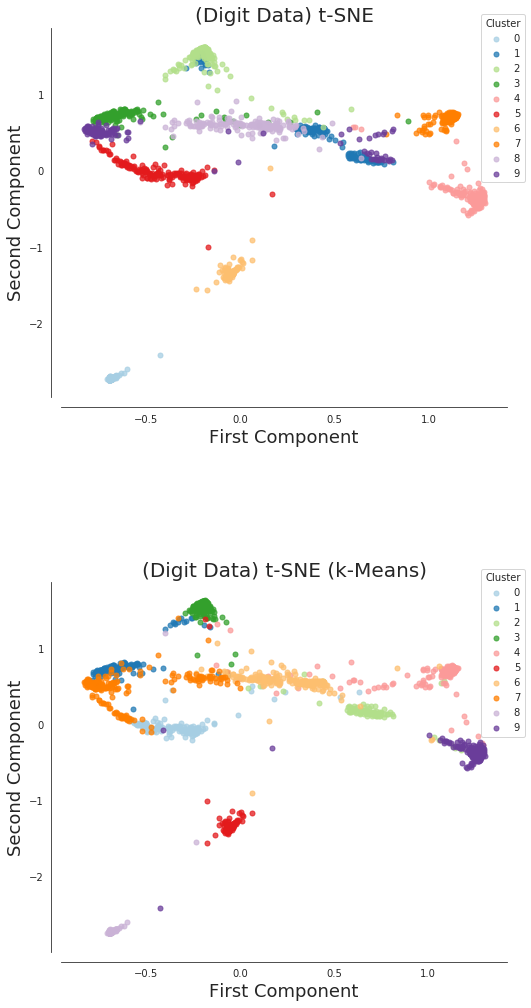

In [20]:
# We select a specific color pallete from Seaborn
# with ten shades.
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("Paired", 10))

# Create Figure and axes
fig, axs = plt.subplots(figsize=(8, 17), nrows=2, ncols=1, sharex=False)
plt.subplots_adjust(hspace=0.5)

# Plot each class separately
for idx in range(10):
    xx = x_tsne.embedding_[(y == idx)]
    xx2 = x_tsne.embedding_[(lbls == idx)]
        
    # Plot the instances of each class in projected dimensions
    axs[0].scatter(xx[:, 0], xx[:, 1], s=25, 
                    color=my_cmap(idx), alpha=0.75,
                    label=f'{idx}')
    
    axs[1].scatter(xx2[:, 0], xx2[:, 1], s=25, 
                    color=my_cmap(idx), alpha=0.75,
                    label=f'{idx}')

    # Decorate plots with legend
    axs[0].legend(title='Cluster', fontsize='medium', 
                  bbox_to_anchor=(1.05, 1.05))
    axs[1].legend(title='Cluster', fontsize='medium', 
                  bbox_to_anchor=(1.05, 1.05))

    #Decorate plot with title and labels
    axs[0].set(title=f'(Digit Data) t-SNE',
               xlabel='First Component',
               ylabel='Second Component')
    axs[1].set(title=f'(Digit Data) t-SNE (k-Means)',
               xlabel='First Component',
               ylabel='Second Component')        

    # Clean plot
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    sns.despine(ax=axs[0], offset=10)
    sns.despine(ax=axs[1], offset=10)        

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used t-SNE to visualize the performance of the k-means algorithm. Now that you have run those code cells, complete the following tasks.

1. Perform k-means clustering on the two-dimensional data generated by the t-SNE algorithm. How do your results compare to the previous figures?   
2. Generate an elbow plot by changing the number of clusters for k-means clustering on the two-dimensional data generated by the t-SNE algorithm. What is the _best_ number of clusters suggested by this plot?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [k-medians][1] clustering
1. Blog article on [k-means clustering][3]
2. The [Scikit Learn k-means algorithm][2]

-----

[1]: https://en.wikipedia.org/wiki/K-medians_clustering
[2]: http://scikit-learn.org/stable/modules/clustering.html#k-means
[3]: https://www.datascience.com/blog/k-means-clustering

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 